In [483]:
from imdbpie import ImdbFacade
from IPython.core.display import display, HTML
from bs4 import BeautifulSoup
import urllib.request
import re
import pandas as pd
import numpy as np

#### Get data for Arnold Schwarzenegger

In [484]:
# Get an instance of IMDb class
imdb = ImdbFacade()

# Search for Arnold Schwarzenegger
people = imdb.search_for_name('Arnold Schwarzenegger')

In [485]:
# Fetch information about him
arnold = imdb.get_name(people[0].imdb_id)

In [486]:
# Let's fetch some more information about a movie
movie = imdb.get_title(arnold.filmography[-1])

In [56]:
date = []
title = []
stars = []
genres = []
rating = []
movies = arnold.filmography

for i in range(len(movies)):
    m = imdb.get_title(arnold.filmography[i])
    date.append(m.release_date)
    title.append(m.title)
    stars.append(m.stars)
    genres.append(m.genres)
    rating.append(m.rating)

In [202]:
df = pd.DataFrame({'date':date,'title':title,'rating':rating,'genres':genres})
df['id'] = movies
df.to_csv('arnold_movies.csv')

In [203]:
df.head()

,date,title,rating,genres,id
0,None,The Original Action Hero,NaN,"(documentary,)",tt4598020
1,None,It's a Fabulous World,NaN,"(documentary,)",tt6727522
2,2007-04-20,The Brotherhood,NaN,"(documentary,)",tt1046268
3,2020-11-24,"Stallone: Frank, That Is",NaN,"(documentary,)",tt6812404
4,1981-09-14,Entertainment Tonight,3.6,"(news,)",tt0081857


In [155]:
def get_box_office(imdb_id):
    # Fetch the box office numbers
    base = 'https://www.boxofficemojo.com'
    url = base + '/title/' + imdb_id
    source = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(source,'lxml')
    table = soup('th', text=re.compile(r'Release Group'))
    if len(table) < 1:
        return [np.nan, np.nan]
    
    else: 
        group = table.findAll('tr', recursive=False)[1].find('a').get('href')[0].parent.parent
        url = base + group

        # Get total earnings domestic and international
        source = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(source,'lxml')
        earnings = soup('h2', text=re.compile(r'Rollout'))[0].parent.parent.findAll('div')
        domestic = earnings[1].find('span', {'class': 'money'}).get_text()
        domestic_url = earnings[1].find('a').get('href')
        international = earnings[2].find('span', {'class': 'money'}).get_text()

        return [domestic, international]

In [192]:
df3 = pd.read_csv('arnold_box_office.csv')
df3['id'] = movies

In [195]:
# found all movies that had values for domestic and international earnings
notnull = df3[((df3['domestic earnings'].notna()) & (df3['international earnings'].notna()))]
notnull = notnull.drop(columns='Unnamed: 0')
notnull.head()

,domestic earnings,international earnings,id
22,"$739,711","$158,281",tt7455754
30,"$100,780","$178,635",tt5495792
89,"$849,521","$52,128",tt2205904
116,"$150,886",$386,tt1413496
155,"$109,107","$4,291",tt0988102


In [196]:
# clean dollar catagory
def clean_earn(str_earn):
    str_earn = str_earn.replace('$', '').replace(',', '')
    return int(str_earn)

In [197]:
notnull['domestic earnings'] = notnull['domestic earnings'].apply(lambda x: clean_earn(x))
notnull['international earnings'] = notnull['international earnings'].apply(lambda x: clean_earn(x))
notnull['total earnings'] = notnull['domestic earnings'] + notnull['international earnings']

In [198]:
notnull.head()

,domestic earnings,international earnings,id,total earnings
22,739711,158281,tt7455754,897992
30,100780,178635,tt5495792,279415
89,849521,52128,tt2205904,901649
116,150886,386,tt1413496,151272
155,109107,4291,tt0988102,113398


In [199]:
notnull.to_csv('arnold_box_office.csv')

In [215]:
# join the tables:
df1 = pd.read_csv('arnold_movies.csv')
df2 = pd.read_csv('arnold_box_office.csv')

In [232]:
df = df1.merge(df2, on='Unnamed: 0').drop(columns='id_y')
df = df.rename(columns={'id_x':'id', 'Unnamed: 0': 'Origional Idx'})

In [233]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))

In [235]:
df.to_csv('arnold_all.csv')

In [453]:
temp = pd.read_csv('arnold_all.csv').drop(columns=['Unnamed: 0'])
temp['date'] = pd.to_datetime(temp['date'])
temp['decade'] = temp['date'].apply(lambda x: ((x.year//10)*10))

,Origional Idx,date,title,rating,genres,id,domestic earnings,international earnings,total earnings
0,22,2018-01-19,The Game Changers,8.2,"('documentary',)",tt7455754,739711,158281,897992
1,30,2017-05-20,Wonders of the Sea 3D,6.4,"('documentary',)",tt5495792,100780,178635,279415
2,89,2013-09-20,Generation Iron,7.1,"('documentary', 'drama', 'sport')",tt2205904,849521,52128,901649
3,116,2011-04-22,Revenge of the Electric Car,7.2,"('documentary',)",tt1413496,150886,386,151272
4,155,2007-09-09,Darfur Now,6.8,"('documentary',)",tt0988102,109107,4291,113398


In [378]:
# information for pie charts
new = temp.groupby('decade').agg({'rating':np.mean,'domestic earnings':np.sum,
                            'international earnings':np.sum,'total earnings':np.sum, 'Origional Idx': 'count'})
new = new.rename(columns={'Origional Idx': 'Counts'})
new

,rating,domestic earnings,international earnings,total earnings,Counts
decade,,,,,
1980,7.100000,284710611,234885010,519595621,5
1990,6.172727,1034876616,1529565815,2564442431,11
2000,6.269231,466720467,594297714,1061018181,13
2010,6.664706,434585827,1277161646,1711747473,17


In [460]:
# add titles
def clean_genre(g):
    pattern = r'[A-Za-z-]+'
    result = re.findall(pattern, g)
    return result
temp['genres'] = temp['genres'].apply(lambda x: clean_genre(x))

In [471]:
row_lst = {'genre':[], 'decade':[], 'total earnings':[]}
for i in range(temp.shape[0]):
    #print(temp.loc[i])
    row = temp.loc[i]
    genres = row.genres
    for i in range(len(genres)):
        curr = genres[i]
        if len(curr) < 1: pass
        else:
            row_lst['genre'] = row_lst['genre'] + [curr]
            row_lst['decade'] =  row_lst['decade'] + [row.decade]
            row_lst['total earnings'] =  row_lst['total earnings'] + [row['total earnings']]            

In [482]:
# info for tree map
from scipy import stats
data = pd.DataFrame(row_lst)
data.groupby(['genre', 'decade']).agg({'total earnings': np.sum})

total earnings
genre       decade                
action      1980         302981233
            1990        2124220999
            2000         859760255
            2010        1697206336
adventure   1980         224610033
            1990         274596978
            2000         152836816
            2010        1494038760
biography   2000           4854164
comedy      1980         216614388
            1990        1093700821
            2000         331940100
crime       1980         216614388
            1990         201957688
            2000          17436509
            2010          17508518
documentary 2000          25153582
            2010          11753033
drama       1990         242295562
            2000          78382433
            2010          21198271
family      1990         129832389
            2000         248283239
fantasy     1980          68851475
            1990         486586021
            2000         176104344
history     2000           4854164
horror      1990         211989043
            2010           2788104
mystery     2000         192170954
news        2000          17436509
romance     1990         108431355
            2000           2998940
sci-fi      1980         176638758
            1990        1124888360
            2000         625542066
            2010         689934834
sport       2010            901649
thriller    1980         155758558
            1990        1094466856
            2000         351211308
            2010        1007271502
western     2000          72178895
            2010          65839275

In [ ]:
# breakdowns for the Pie Chart

In [442]:
eightys = temp[temp['decade'] == 1980]

import itertools
list2d = list(eightys['genres'].values)
merged = list(itertools.chain(*list2d))
pd.Series(merged).value_counts()

action       4
adventure    3
thriller     2
sci-fi       2
crime        1
comedy       1
fantasy      1
dtype: int64

In [447]:
ninghtys = temp[temp['decade'] == 1990]
list2d = list(ninghtys['genres'].values)
merged = list(itertools.chain(*list2d))
pd.Series(merged).value_counts()

action       8
comedy       6
sci-fi       4
thriller     4
fantasy      3
adventure    2
romance      1
drama        1
horror       1
family       1
crime        1
dtype: int64

In [449]:
thou = temp[temp['decade'] == 2000]
list2d = list(thou['genres'].values)
merged = list(itertools.chain(*list2d))
pd.Series(merged).value_counts()

action         7
documentary    5
comedy         4
thriller       4
sci-fi         3
adventure      2
family         2
mystery        2
news           1
crime          1
biography      1
history        1
fantasy        1
romance        1
western        1
drama          1
dtype: int64

In [451]:
tens = temp[temp['decade'] == 2010]
list2d = list(tens['genres'].values)
merged = list(itertools.chain(*list2d))
pd.Series(merged).value_counts()

action         8
documentary    7
thriller       6
adventure      5
drama          4
horror         2
sci-fi         2
western        2
crime          1
sport          1
dtype: int64

# Timeline

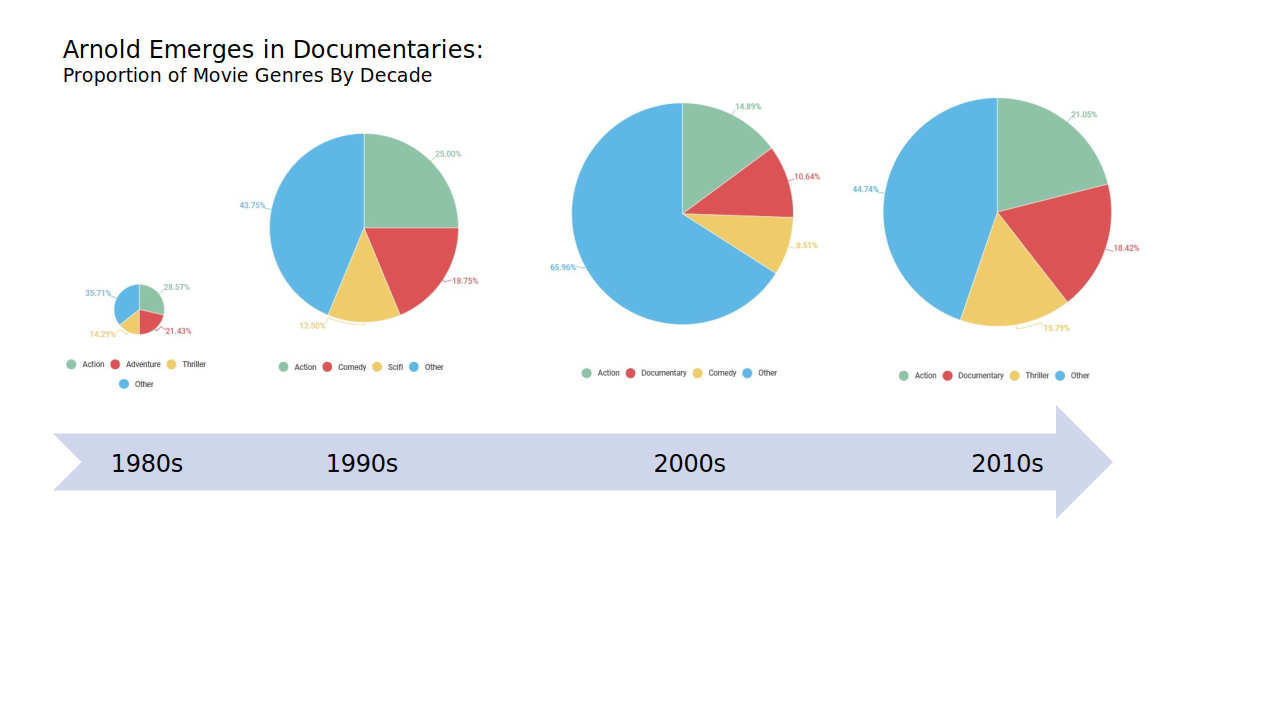

In [488]:
SVG(filename='dsc106_hw4.svg')

My inspiration from this chart came from wanted to express how not only the number of movies Arnold appeared in grew over time but also how the types of movies he appeared in changed. The sizes of the pie charts in the timeline are proportional to the number of movie he filmed in the corresponding decade. 1980s (14), 1990s (32), 2000s (37), and 2010s (38). I chose to only include the top 3 genres because I wanted to keep in mind Miller's Law (7 +/- 2 will keep my view interested).  

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [335]:
# word cloud word
di = {}
gen = list(genre_stats.index)
for g in gen:
    di[g] = [0, 0]
    
for i in range(df1.shape[0]):
    row = df1.iloc[i]
    for g in row.clean_genres:
        if len(g) == 0: pass
        
        else:
            if np.isnan(row.rating): pass
            else:
                di[g][0] += row.rating
                di[g][1] += 1
for g in gen:
    di[g] = di[g][0] / di[g][1]

In [338]:
# helped color code the word cloud
avg_rating = di
avg_rating

{'documentary': 6.798695652173912,
 'comedy': 6.564661654135339,
 'talk-show': 5.838938053097347,
 'news': 5.222680412371133,
 'short': 6.685507246376812,
 'action': 6.388059701492535,
 'music': 6.735416666666666,
 'biography': 6.8315789473684205,
 'sport': 7.365714285714285,
 'thriller': 6.19090909090909,
 'drama': 6.2,
 'family': 5.95925925925926,
 'sci-fi': 6.592000000000001,
 'adventure': 6.1000000000000005,
 'history': 7.482352941176471,
 'crime': 6.474999999999999,
 'reality-tv': 5.875,
 'fantasy': 6.007142857142858,
 'game-show': 6.269230769230769,
 'romance': 5.789999999999999,
 'horror': 6.6428571428571415,
 'mystery': 6.983333333333333,
 'western': 5.824999999999999,
 'animation': 7.539999999999999,
 'war': 5.833333333333333,
 'musical': 4.1}

# Genre Cloud

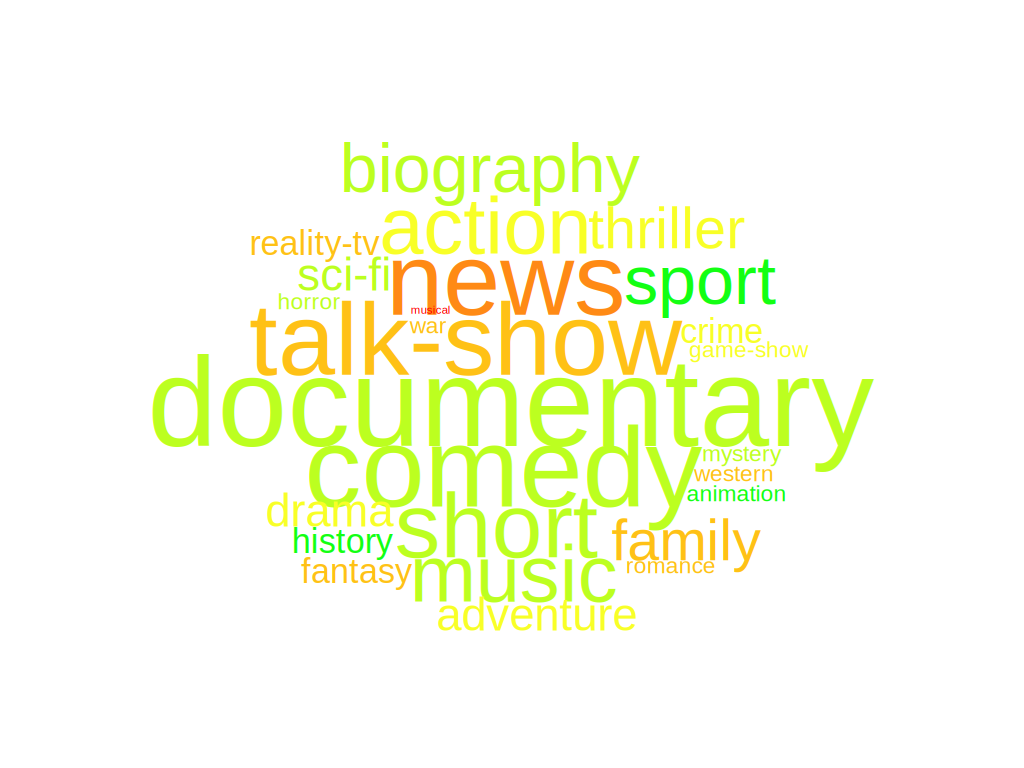

In [487]:
from IPython.core.display import SVG
SVG(filename='wordcloud.svg')

<img src="wc_legend.png">

My inspiration for this visual was finding a way to show which genres were the most popular while adding another dimension to the data. I decided to go with average rating per/ genre. This shows us not only which genres has the most movies made but also how popular the genre was. I broke up the color scale by using the min and max rating as a reference point and making the step betweenn each color even.

In [ ]:
# see js file in repo for third vis

My inspiration for Tree Map came from wanting to use the box office data in some way. I would like to explore the concept of "drilling" more in the final project but I thought the tree map was a cool way to represent the proportions of money from the box office that went to each genre and also how it changed over the decades. 